In [34]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


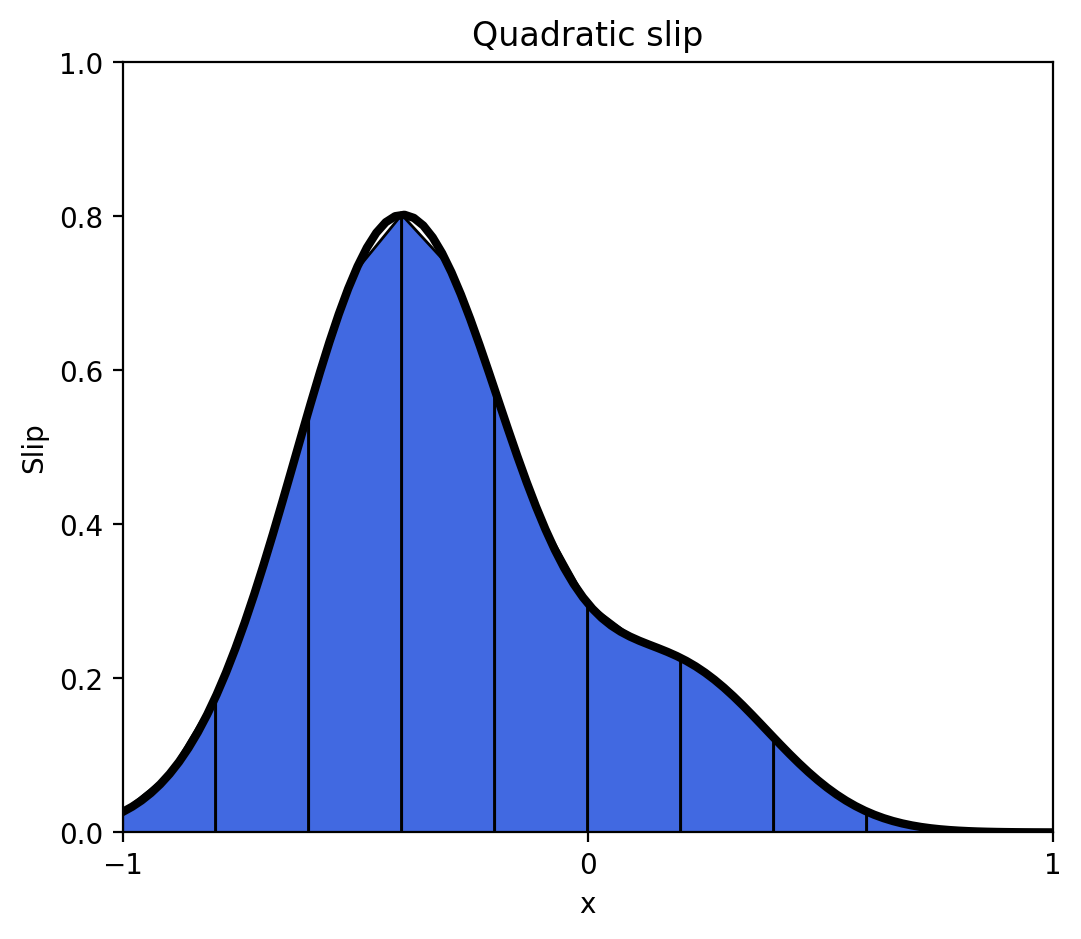

In [35]:
n_pts = 11
n_els = n_pts - 1
a = 1  # fault half-length

x_vals = np.linspace(-a, a, n_pts)

# Define a smooth slip function
func_slip = lambda x: 0.8 * np.exp(-((x + 0.4) ** 2) / 2 / (0.23**2)) + 0.2 * np.exp(
    -((x - 0.2) ** 2) / 2 / (0.2**2)
)
slip_values = func_slip(x_vals)

# Define a piecewise constant apprximation to quadratic
x1 = np.zeros(n_els)
x2 = np.zeros(n_els)
constant_slip = np.zeros(n_els)
quadratic_coefs = np.zeros((n_els, 3))

for i in range(n_els):
    x1[i] = x_vals[i]
    x2[i] = x_vals[i + 1]
    constant_slip[i] = 0.5 * (slip_values[i] + slip_values[i + 1])
    x = np.array([x1[i], 0.5 * (x1[i] + x2[i]), x2[i]])
    quadratic_coefs[i, :] = bemcs.phicoef(x, func_slip(x), 0.5 * (x2[i] - x1[i]))

plt.figure(figsize=(6, 5))
# Quadratic elements
for i in range(n_els):
    x1[i] = x_vals[i]
    x2[i] = x_vals[i + 1]
    x = np.array([x1[i], 0.5 * (x1[i] + x2[i]), x2[i]])

    plt.fill(
        np.hstack([x, np.flip(x)]),
        np.hstack([func_slip(x), 0, 0, 0]),
        "royalblue",
        alpha=1,
        edgecolor="k",
    )
x = np.linspace(-a, a, 100)
# plt.fill(
#     np.hstack([x, np.flip(x)]),
#     np.hstack([func_slip(x), x * 0]),
#     "royalblue",
#     alpha=1,
#     edgecolor="k",
# )
plt.plot(x, func_slip(x), "k-", linewidth=3)
plt.xlim([-a, a])
plt.xticks([-a, 0, a])
plt.ylim([0, 1])
plt.xlabel("x")
plt.ylabel("Slip")
plt.title("Quadratic slip")
plt.show()

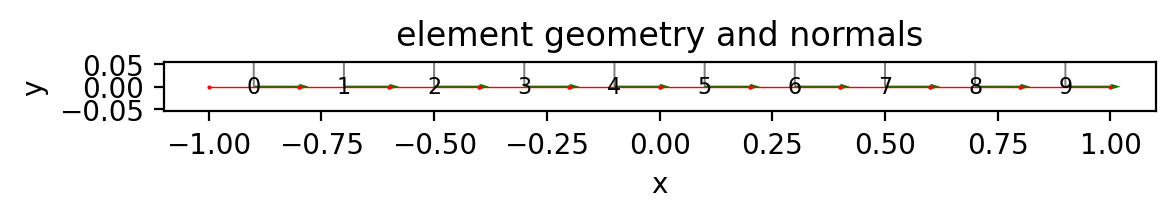

In [36]:
els = bemcs.initialize_els()
els.x1 = x1
els.y1 = np.zeros_like(x1)
els.x2 = x2
els.y2 = np.zeros_like(x1)
bemcs.standardize_els_geometry(els)
bemcs.plot_els_geometry(els)

In [37]:
mu = 1
nu = 0.25

npts = 500
x_obs = np.linspace(-a, a, npts).reshape(-1, 1)
y_obs = np.zeros_like(x_obs) + 1e-8

# Compute shear and tensile stress kernels (constant slip kernels)
kernels_s = bemcs.get_displacement_stress_kernel_constant(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel_constant(
    x_obs, y_obs, els, mu, nu, flag="normal"
)
ux_constant, _, sxx_constant, syy_constant, sxy_constant = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, constant_slip, constant_slip * 0
)

# Compute quadratic coefs that allow for continuous slip

In [38]:
# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride))
bc_vec[0:2] = 0.0
bc_vec[-2:] = 0.0
bc_vec[2::stride] = constant_slip
bc_vec[3::stride] = 0

# Populate design matrix
# Boundary nodes
design_mat[0:2, :] = slip_mat[0:2]
design_mat[-2:, :] = slip_mat[-2:, :]

# Patch center nodes
design_mat[2::stride, :] = slip_mat[2::stride, :]
design_mat[3::stride, :] = slip_mat[3::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity (x component)
design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

# Slip continuity (x component)
design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

# Smoothness
# x component
design_mat[6:-5:stride, :] = (
    slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
)
# y component
design_mat[7:-4:stride, :] = (
    slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(design_mat) @ bc_vec

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

# Compute shear and tensile stress kernels (quadratic kernels)
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)
ux_quad, _, sxx_quad, syy_quad, sxy_quad = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)

# Plot slip and shear stress comparison

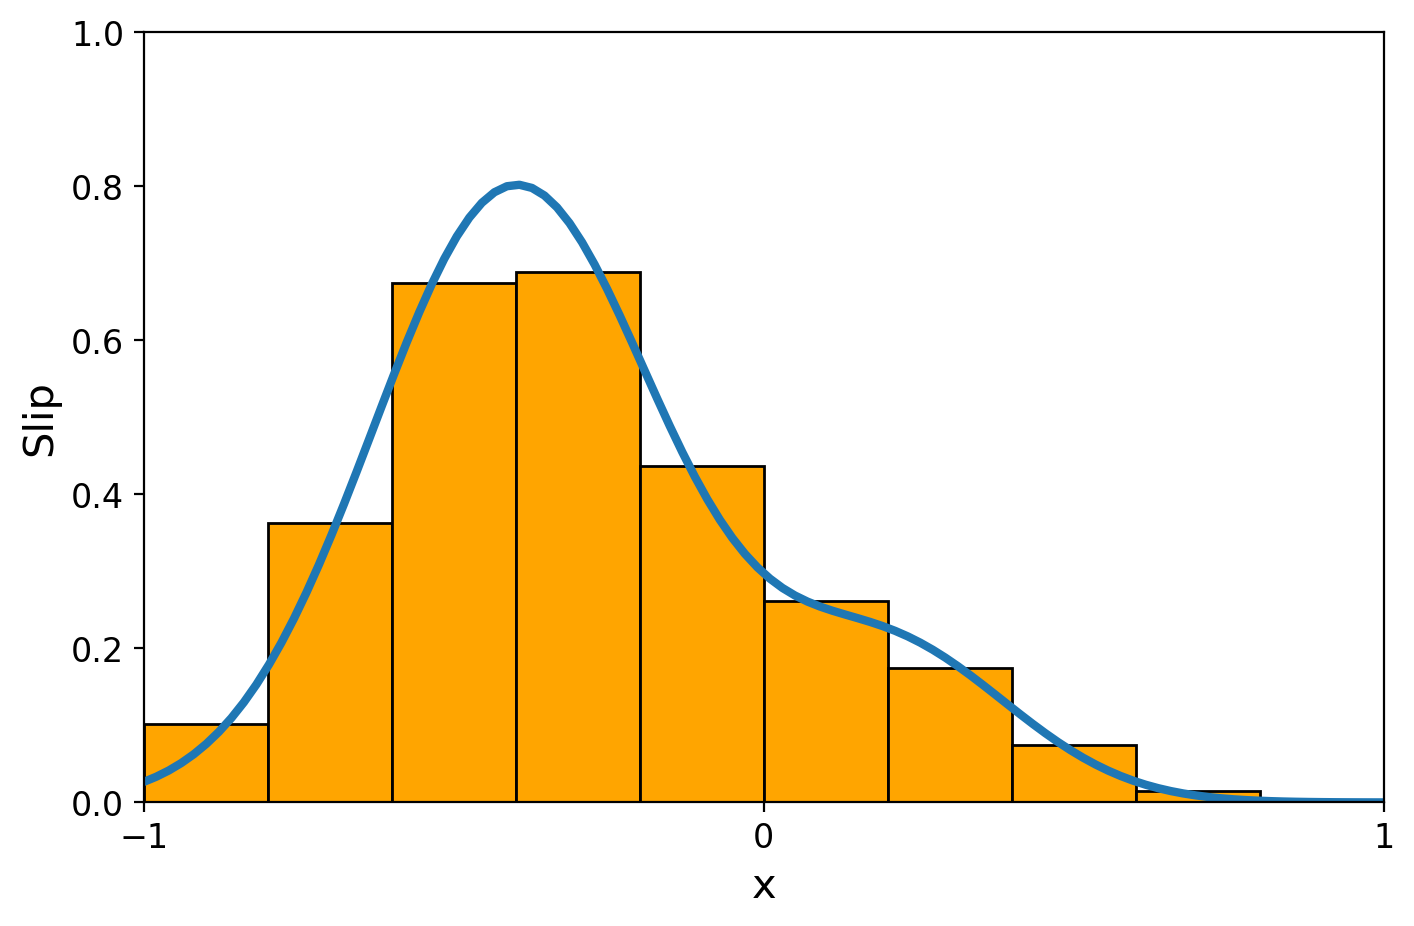

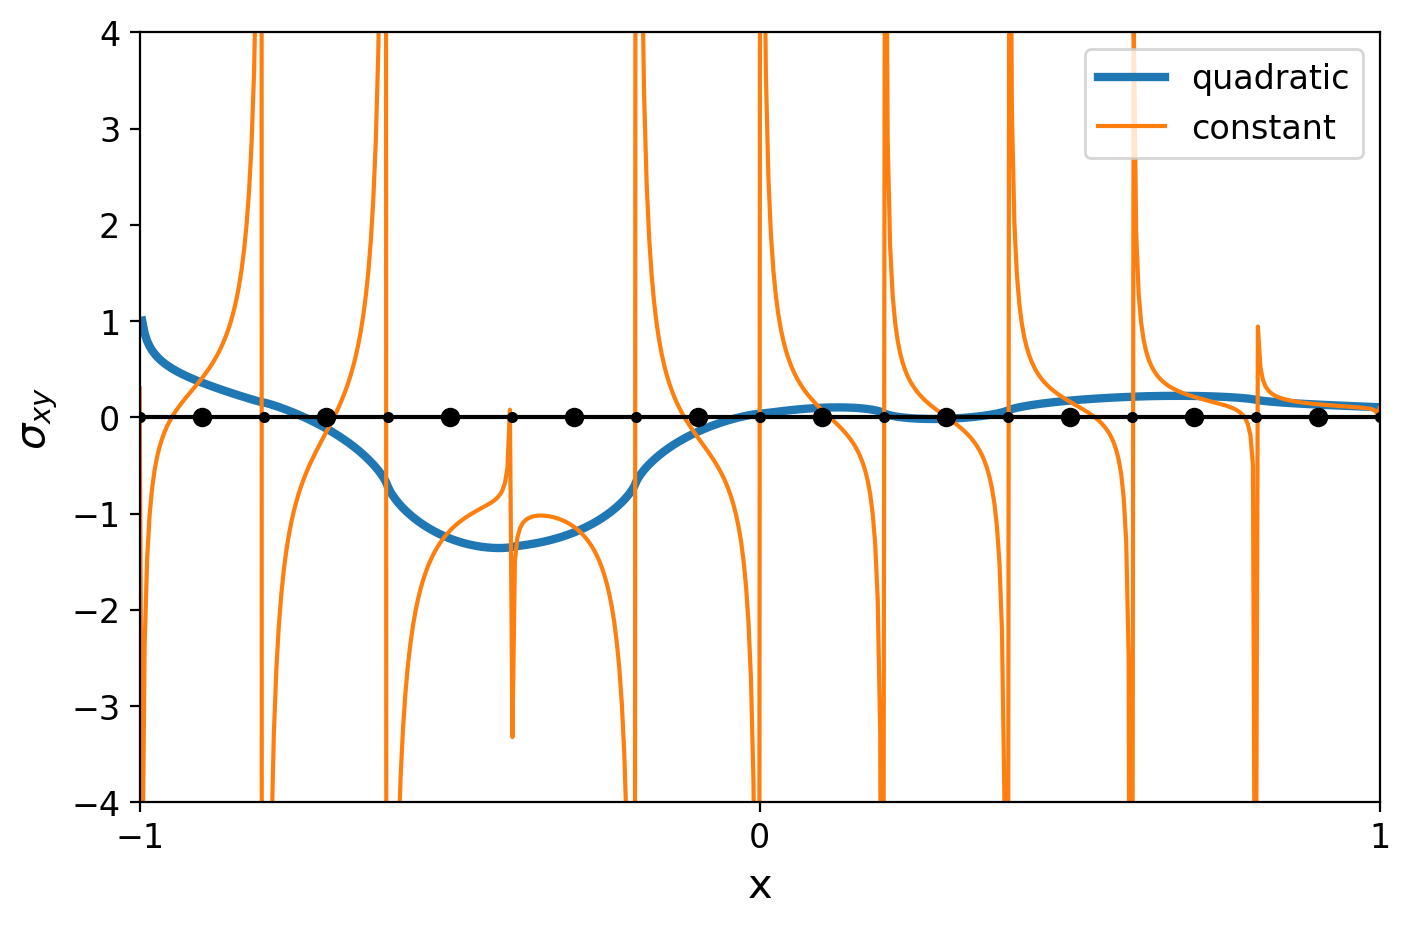

In [40]:
plt.figure(figsize=(8, 5))
for i in range(n_els):
    plt.fill(
        [x1[i], x2[i], x2[i], x1[i]],
        [constant_slip[i], constant_slip[i], 0, 0],
        "orange",
        alpha=1,
        edgecolor="k",
    )

plt.plot(x, func_slip(x), "-", linewidth=3)
plt.xlim([-a, a])
plt.xticks([-a, 0, a])
plt.ylim([0, 1])
plt.xlabel("x", fontsize=15)
plt.ylabel("Slip", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(x_obs, sxy_quad, label="quadratic", linewidth=3)
plt.plot(x_obs, sxy_constant, label="constant")
plt.plot(els.x_centers, 0 * els.x_centers, "ko")
plt.plot(x_vals, 0 * x_vals, "k.-")
plt.legend(fontsize=12)
plt.ylim(-4, 4)
plt.xlim(np.min(x_obs), np.max(x_obs))
plt.xticks([-a, 0, a])
plt.xlabel("x", fontsize=15)
plt.ylabel("$\sigma_{xy}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()